**CUSTOMER CHURN PRDICTION ANALYSIS**

**Hypothesis**

The number of Female to churn are more than the churning rate of Males.

**Some Questions Asked**

what is the churn rate distribution between people who churned and people who did not churn

Which features have the most impact on predicting customers churn?

what is the churn rate by gender

what is the churn rate per partner

what is the churn rate per dependents

what is the churn rate per seniorcitizen

churn rate per tenure.

Which model is the best for predicting churn?

**Importing libraries and reading csv file**

In [74]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import plotly.express as px
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)
from category_encoders import *

# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

#Import metric for performance evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

In [75]:
data = pd.read_csv (r"C:\Users\selas\OneDrive\Desktop\Telco-Customer-Churn.csv")
data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


From the info above, we can see there are no null values. But lets go ahead and check if there are empty cells and replace them with nan. since sometimes there can be empty cells.

In [76]:
data = data.replace(r'^\s*$', np.nan, regex=True)
data.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

And now we can see that TotalCharges column has 11 null values

Lets fill the missing values with the meadian of the tatal charges

In [77]:
#changing the format from object to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'],errors='coerce')
#Fill the missing values with the median value
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())

lets check for duplicate rows

In [78]:
data.duplicated().sum()

0

there are no duplicates

In [79]:
data.shape

(7043, 21)

There are 7043 customers and 21 features in the dataset. The data has 17 categorical features and 3 numeric features (tunure, monthlycharges and totalcharges) and Prediction feature (Churn).

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [81]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


**Exploring the Target Variable**

In [82]:
churn_distribute = data['Churn'].value_counts().to_frame()
churn_distribute = churn_distribute.reset_index()
churn_distribute = churn_distribute.rename(columns={'index': 'Category'})
fig = px.pie(churn_distribute, values = 'Churn', names='Category', color_discrete_sequence=["green", "red"],
             title='Distribution of Churn')
fig.show()

churn distribution per the dataset;

We have an imbalanced data.(because there is an unequal distribution between people who churn and people who didnt churn)

No - 73.5% (people who did not churn were about 5174 out of 7043)

Yes - 26.5% (people who churned were about 1869 out of 7043)

In [83]:
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])

fig.add_trace(go.Pie(labels = data['gender'].unique(), values = data['gender'].value_counts(), name ='Gender', 
                     marker_colors = ['red', 'green']), 1, 1)

fig.update_traces(hole=0.5, textfont_size=20, marker=dict(line=dict(color='black', width=2)))

fig.update_layout(
    title_text='<b>Gender Distributions<b>', 
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Gender', x=0.19, y=0.5, font_size=20, showarrow=False)])
iplot(fig)

we can also see from this pie chart that the customers are 49.5% males and 50.5% females

In [84]:
fig = px.sunburst(data, path=['Churn', 'gender'], title='<b>Sunburst Plot of Gender and churn<b>')
iplot(fig)


**Exploring features**

In [85]:
#Defining bar chart function
def bar(feature, df = data ):

    #Groupby the categorical feature
    temp_df = df.groupby([feature, 'Churn']).size().reset_index()
    temp_df = temp_df.rename(columns = {0:'Count'})

    #Calculate the value counts of each distribution and it's corresponding Percentages
    value_counts_df = df[feature].value_counts().to_frame().reset_index()
    categories = [cat[1][0] for cat in value_counts_df.iterrows()]

    #Calculate the value counts of each distribution and it's corresponding Percentages
    num_list = [num[1][1] for num in value_counts_df.iterrows()]
    div_list = [element / sum(num_list) for element in num_list]
    percentage = [round(element * 100,1) for element in div_list]
    
    #Defining string formatting for graph annotation
    #Numeric section
    def num_format(list_instance):
        formatted_str = ''
        for index,num in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{num}%, ' #append to empty string(formatted_str)
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{num}% & '
            else:
                formatted_str=formatted_str+f'{num}%'
        return formatted_str
    #Categorical section
    def str_format(list_instance):
        formatted_str = ''
        for index, cat in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{cat}, '
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{cat} & '
            else:
                formatted_str=formatted_str+f'{cat}'
        return formatted_str


    #Running the formatting functions
    num_str = num_format(percentage)
    cat_str = str_format(categories)
    
    #Setting graph framework
    fig = px.bar(temp_df, x=feature, y='Count', color='Churn', title=f'Churn rate by {feature}', barmode="group", color_discrete_sequence=["green", "red"])
    fig.add_annotation(
                text=f'Value count of distribution of {cat_str} are<br>{num_str} percentage respectively.',
                align='left',
                showarrow=False,
                xref='paper',
                yref='paper',
                x=1.4,
                y=1.3,
                bordercolor='black',
                borderwidth=1)
    fig.update_layout(
        # margin space for the annotations on the right
        margin=dict(r=400),
    )
     
    return fig.show()

**Exploring Categorical features**

In [86]:
#Gender feature plot
bar('gender')

In [87]:
print(f'A female customer has a probability of {round(data[(data["gender"] == "Female") & (data["Churn"] == "Yes")].count()[0] / data[(data["gender"] == "Female")].count()[0] *100,2)} % churn')

print(f'A male customer has a probability of {round(data[(data["gender"] == "Male") & (data["Churn"] == "Yes")].count()[0] / data[(data["gender"] == "Male")].count()[0] *100,2)} % churn')

A female customer has a probability of 26.92 % churn
A male customer has a probability of 26.16 % churn


There is negligible difference in customer percentage who changed the service provider. Both genders behaved in similar way when it comes to migrating to another service provider.

In [88]:
#SeniorCitizen feature plot 
data.loc[data.SeniorCitizen==0,'SeniorCitizen'] = "No"   #convert 0 to No in all data instances
data.loc[data.SeniorCitizen==1,'SeniorCitizen'] = "Yes"  #convert 1 to Yes in all data instances
bar('SeniorCitizen')

There’s a higher proportion of churn in younger customers (SeniorCitizen = No)

In [89]:
#Partner feature plot
bar('Partner')

There’s a higher proportion of churn in customers with no partners.

In [90]:
#Dependents feature plot
bar('Dependents')

There’s a higher proportion of churn in customers with no dependents

The demographic section of data highlights on-senior citizens with no partners and dependents as a particular segment of customers likely to churn.

In [91]:
bar('PhoneService')

In [92]:
print(f'A customer with phone service has a probability of {round(data[(data["PhoneService"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["PhoneService"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without phone service has a probability of {round(data[(data["PhoneService"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["PhoneService"] == "No")].count()[0] *100,2)} % churn')

A customer with phone service has a probability of 26.71 % churn
A customer without phone service has a probability of 24.93 % churn


Customers with phone services are more likely to churn

Very small fraction of customers don't have a phone service and out of that, about 25% Customers are more likely to churn.

In [93]:
bar('MultipleLines')

In [94]:
bar('InternetService')

A lot of customers choose the Fiber optic service and it's also evident that the customers who use Fiber optic have high churn rate, this might suggest a dissatisfaction with this type of internet service. This may be due to high prices, competition, customer service, and many other reasons. Fiber optic service is much more expensive than DSL which may be one of the reasons why customers churn.

Customers having DSL service are majority in number and have less churn rate compared to Fiber optic service.

In [95]:
bar('OnlineSecurity')

In [96]:
print(f'A customer with an online security has a probability of {round(data[(data["OnlineSecurity"] == "Yes") & (data["Churn"] == "Yes")].count()[0] / data[(data["OnlineSecurity"] == "Yes")].count()[0] *100,2)} % churn')

print(f'A customer without an online security has a probability of {round(data[(data["OnlineSecurity"] == "No") & (data["Churn"] == "Yes")].count()[0] / data[(data["OnlineSecurity"] == "No")].count()[0]*100,2)} % churn')

print(f'A customer with no internet service has a probability of {round(data[(data["OnlineSecurity"] == "No internet service") & (data["Churn"] == "Yes")].count()[0] / data[(data["OnlineSecurity"] == "No internet service")].count()[0]*100,2)} % churn')


A customer with an online security has a probability of 14.61 % churn
A customer without an online security has a probability of 41.77 % churn
A customer with no internet service has a probability of 7.4 % churn


Most customers churn in the absence of online security.

In [97]:
bar('OnlineBackup')

Customers with no online Backup turn to churn more.

In [98]:
bar('DeviceProtection')

customers with no device protection turn to churn more

In [99]:
bar('TechSupport')

customers with no techsupport churn more

In [100]:
bar('StreamingTV')

In [101]:
bar('StreamingMovies')

In [102]:
bar('Contract')
bar('PaperlessBilling')
bar('PaymentMethod')

Payment insights

1- The shorter the contract, the higher the churn rate. Those with more extended plans face additional barriers when canceling early. This clearly explains the motivation for companies to have long-term relationships with their customers.

2- Churn Rate is higher for the customers who opted for paperless billing. About 59.2% of customers use paperless billing. 

3- Customers who pay with electronic checks are more likely to churn.

In [103]:
fig = px.histogram(data, x='TotalCharges', color='Churn', marginal='box', title='<b>Churn rate to Total Charges Distribution<b>',
             color_discrete_sequence = ['blue', 'red'])
iplot(fig)

Output plot of the histogram on total charges with respect to churn rate

In [104]:
fig = px.histogram(data, x='MonthlyCharges', color='Churn', marginal='box', title='<b> Churn Rate to Monthly Charges Distribution<b>',
             color_discrete_sequence = ['yellow', 'red'])
iplot(fig)

Output plot of the histogram on monthly charges with respect to churn rate

In [105]:
fig = px.histogram(data, x='tenure', color='Churn', marginal='box', title='<b>Churn rate to Tenure Distribution<b>',
             color_discrete_sequence = ['orange', 'red'])
iplot(fig)

Output plot of the histogram on tenure with respect to churn rate

In [106]:
#Create an empty dataframe
bin_df = pd.DataFrame()

#Update the binning dataframe
bin_df['tenure_bins'] =  pd.qcut(data['tenure'], q=3, labels= ['low', 'medium', 'high'])
bin_df['MonthlyCharges_bins'] =  pd.qcut(data['MonthlyCharges'], q=3, labels= ['low', 'medium', 'high'])
bin_df['TotalCharges_bins'] =  pd.qcut(data['TotalCharges'], q=3, labels= ['low', 'medium', 'high'])
bin_df['Churn'] = data['Churn']

#Plot the bar chart of the binned variables
bar('tenure_bins', bin_df)
bar('MonthlyCharges_bins', bin_df)
bar('TotalCharges_bins', bin_df)

Based on binning, the low tenure and high monthly charge bins have higher churn rates as supported with the previous analysis. While the low Total charge bin has a higher churn rate. So we can say,

Customers with low Total Charges are more likely to churn.

Customers with higher Monthly Charges are more likely to churn.

Customers who stayed with the company for longer time are less likely to churn.

**Detecting Outliers**

In [107]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=data['MonthlyCharges'], notched=True, name='Monthly Charges', marker_color = '#6699ff', 
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 2)

fig.add_trace(go.Box(y=data['TotalCharges'], notched=True, name='Total Charges', marker_color = '#ff0066', 
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 1)

fig.add_trace(go.Box(y=data['tenure'], notched=True, name='Tenure', marker_color = 'lightseagreen', 
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 3)

fig.update_layout(title_text='Box Plots for Numerical Variables')

iplot(fig)

The boxplots do not show any outliers from the above.

**Variable encoding for categorical data**

In [108]:
# Encoding target feature

data['Churn'] = data['Churn'].map({'Yes':1,'No':0})

In [109]:
data.dtypes

customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

The customerID column isnt very useful as the feature is used to identify customers. 
so it will be dropped.

In [110]:
data.drop(["customerID"],axis=1,inplace = True)

**getting categorical columns and encoding them**

In [111]:
categorical = data.select_dtypes("object").columns

In [112]:
def category(df):
    for var in categorical:
        ordered_labels = df.groupby([var])['Churn'].mean().sort_values().index

        ordinal_label = {k:i for i, k in enumerate(ordered_labels, 0)} 
        ordinal_label
        df[var] = df[var].map(ordinal_label)

category(data)

 using Target guided ordinal encoding. Ordering the categories according to the target means assigning a number to the category, but this numbering, this ordering, is informed by the mean of the target within the category. Briefly, we calculate the mean of the target for each label/category, then we order the labels according to these mean from smallest to biggest, and we number them accordingly.In this method, we calculate the mean of each categorical variable based on the target.

Advantages:

Capture information within the label, therefore rendering more predictive features

Does not expand the feature space

Disadvantage:

Prone to cause over-fitting

In [113]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1,0,0,1,1,0,0,1,2,1,2,2,2,2,2,1,3,29.85,29.85,0
1,0,0,1,1,34,1,1,1,1,2,1,2,2,2,1,0,2,56.95,1889.50,0
2,0,0,1,1,2,1,1,1,1,1,2,2,2,2,2,1,2,53.85,108.15,1
3,0,0,1,1,45,0,0,1,1,2,1,1,2,2,1,0,1,42.30,1840.75,0
4,1,0,1,1,2,1,1,2,2,2,2,2,2,2,2,1,3,70.70,151.65,1


In [114]:
X = data.drop(['Churn'], axis = 1)
y = data['Churn']


**splitting data into train and test data**

In [115]:
# preprocessing (Standardization(feature scalling)  and  dataset spliting)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

In [116]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape

((6338, 19), (705, 19))

**Standardization**

In [117]:
#standardization
scaler = StandardScaler()
X_train[['TotalCharges','MonthlyCharges','tenure']] = scaler.fit_transform(X_train[['TotalCharges','MonthlyCharges','tenure']])
X_test[['TotalCharges','MonthlyCharges','tenure']] = scaler.transform(X_test[['TotalCharges','MonthlyCharges','tenure']]) 

**Balancing of data**

As shown previously, we are dealing with an imbalanced dataset. The BorderlineSMOTE method will be used to balance the data, which involves selecting those instances of the minority class that are misclassified, such as with a k-nearest neighbor classification model. This method oversamples just those difficult instances, providing more resolution only where it may be required.

In [118]:
# balance data
from imblearn.over_sampling import BorderlineSMOTE

oversample = BorderlineSMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

**MODEL BUILDING**

**Writing a function for models**

In [119]:
#Defining the modelling function
def modeling(alg, alg_name, params={}):
    model = alg(**params) #Instantiating the algorithm class and unpacking parameters if any
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    #Performance evaluation
    def print_scores(alg, y_true, y_pred):
        print(alg_name)
        acc_score = accuracy_score(y_true, y_pred)
        print("accuracy: ",acc_score)
        pre_score = precision_score(y_true, y_pred)
        print("precision: ",pre_score)
        rec_score = recall_score(y_true, y_pred)                            
        print("recall: ",rec_score)
        f_score = f1_score(y_true, y_pred, average='weighted')
        print("f1_score: ",f_score)
        f_score_2 = fbeta_score(y_test, y_pred, beta=2.0)
        print("f2_score: ",f_score_2)

    print_scores(alg, y_test, y_pred)
    return model

**Model 1; Logistic Regression**

In [120]:
# Running logistic regression model
log_model = modeling(LogisticRegression, 'Logistic Regression')

Logistic Regression
accuracy:  0.7163120567375887
precision:  0.4913294797687861
recall:  0.8762886597938144
f1_score:  0.7314565727380595
f2_score:  0.7575757575757577


**Model 2; RandomForest Classifier**

In [121]:
#Random forest
rf_model = modeling(RandomForestClassifier, "Random Forest Classification")

Random Forest Classification
accuracy:  0.775886524822695
precision:  0.5789473684210527
recall:  0.6804123711340206
f1_score:  0.7810585892598173
f2_score:  0.6573705179282868


**Model 3; DecissionTree model**


In [122]:
#Decision tree
dt_model = modeling(DecisionTreeClassifier, "Decision Tree Classification")

Decision Tree Classification
accuracy:  0.7063829787234043
precision:  0.47368421052631576
recall:  0.6030927835051546
f1_score:  0.7159968578696877
f2_score:  0.5718475073313782


**Model 4; XG boost**

In [123]:
xgb_model = modeling(XGBClassifier, "XG Boost classifier")

XG Boost classifier
accuracy:  0.7602836879432624
precision:  0.5518672199170125
recall:  0.6855670103092784
f1_score:  0.7674561017363659
f2_score:  0.6538839724680432


**Model 5; Naive Bayes**

In [124]:
#Naive bayes 
nb_model = modeling(GaussianNB, "Naive Bayes Classification")

Naive Bayes Classification
accuracy:  0.6780141843971631
precision:  0.45646437994722955
recall:  0.8917525773195877
f1_score:  0.6944088408241124
f2_score:  0.748917748917749


**Model 6; AdaBoost**

In [125]:
#AdaBoost
              
AdaBoost_model = modeling(AdaBoostClassifier, "AdaBoost Classifier")

AdaBoost Classifier
accuracy:  0.7390070921985815
precision:  0.5152439024390244
recall:  0.8711340206185567
f1_score:  0.7528141494392412
f2_score:  0.7653985507246377


***FEATURE IMPORTANCE***

What features contribute more to predict the target (Churn)? let's find out how useful they are at predicting the target variable.

Random Forest algorithm offer importance scores based on the reduction in the criterion used to select split points, like Gini or entropy.

In [126]:
RF_I = RandomForestClassifier(n_estimators=70, random_state=42)
RF_I.fit(X, y)

RandomForestClassifier(n_estimators=70, random_state=42)

In [127]:
d = {'Features': X_train.columns, 'Feature Importance': RF_I.feature_importances_}
df = pd.DataFrame(d)
df_sorted = df.sort_values(by='Feature Importance', ascending = False)
df_sorted
df_sorted.style.background_gradient(cmap='Blues')

,Features,Feature Importance
18,TotalCharges,0.187982
17,MonthlyCharges,0.170396
4,tenure,0.158677
14,Contract,0.084465
16,PaymentMethod,0.052478
7,InternetService,0.041508
11,TechSupport,0.039720
8,OnlineSecurity,0.039524
0,gender,0.028380
9,OnlineBackup,0.024959


In [128]:
fig = px.bar(x=df_sorted['Feature Importance'], y=df_sorted['Features'], color_continuous_scale=px.colors.sequential.Blues,
             title='Feature Importance Based on Random Forest', text_auto='.4f', color=df_sorted['Feature Importance'])

fig.update_traces(marker=dict(line=dict(color='black', width=2)))
fig.update_layout({'yaxis': {'title':'Features'}, 'xaxis': {'title':'Feature Importance'}})

iplot(fig)

The first 3 most imortant features are TotalCharges, MonthlyCharges and Tenure

**The best model among all the models used is the *RandomForest Classifier*. it has the highest F1_score of 0.78**

**Model Evaluation**

In [129]:
# Feature selection to improve model building
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
rf = RandomForestClassifier()
rfecv = RFECV(estimator=rf, cv=StratifiedKFold(10, random_state=50, shuffle=True), scoring="accuracy")
rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=50, shuffle=True),
      estimator=RandomForestClassifier(), scoring='accuracy')

Visualizing k-fold cross validation

c:\Users\selas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning:

The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.



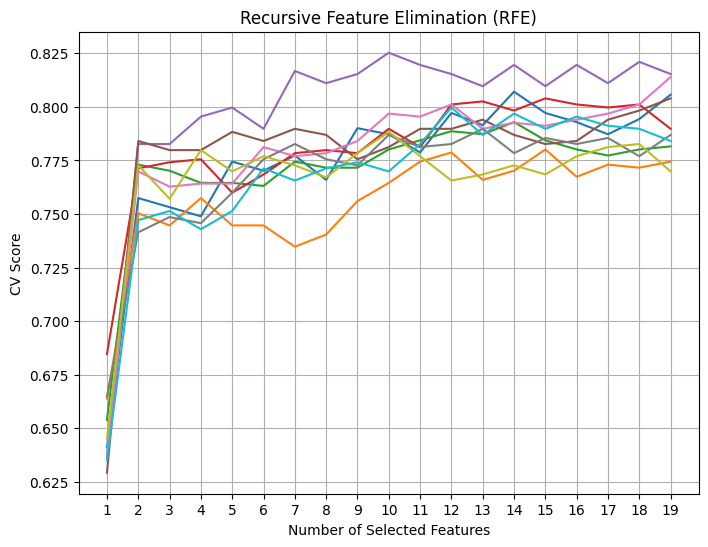

The optimal number of features: 19


In [130]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(rfecv.grid_scores_)+1), rfecv.grid_scores_)
plt.grid()
plt.xticks(range(1, X.shape[1]+1))
plt.xlabel("Number of Selected Features")
plt.ylabel("CV Score")
plt.title("Recursive Feature Elimination (RFE)")
plt.show()

print("The optimal number of features: {}".format(rfecv.n_features_))

In [131]:
#Saving dataframe with optimal features
X_rfe = X.iloc[:, rfecv.support_]

**Model Evaluation and Improving best model by hyperparameter tuning**

In [132]:
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [133]:
# Improve best model by hyperparameter tuning
# define model
model = RandomForestClassifier()

# define evaluation
from sklearn.model_selection import RepeatedStratifiedKFold, HalvingGridSearchCV
from sklearn.experimental import enable_halving_search_cv
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
              
   
Halving_grid = HalvingGridSearchCV(estimator=RandomForestClassifier(), param_grid = param_grid, min_resources='exhaust', verbose = 2, n_jobs=-1) 
   
# fitting the model for grid search 
grid_results = Halving_grid.fit(X_train, y_train) 
 
#print best parameter after tuning 
print(grid_results.best_params_) 

#make prediction using the best model
grid_predictions = grid_results.predict(X_test) 
   
# performance metrics
#f1 = f1_score(y_test, grid_predictions)
#f1

# define search
from sklearn.model_selection import RandomizedSearchCV
search = RandomizedSearchCV(RandomForestClassifier, param_grid, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)

# execute search
#result = search.fit(X_rfe, y)
# summarize result
# print('Best Score: %s' % result.best_score_)
# print('Best Hyperparameters: %s' % result.best_params_)
#params = result.best_params_

n_iterations: 6
n_required_iterations: 6
n_possible_iterations: 6
min_resources_: 38
max_resources_: 9326
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 288
n_resources: 38
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
----------
iter: 1
n_candidates: 96
n_resources: 114
Fitting 5 folds for each of 96 candidates, totalling 480 fits
----------
iter: 2
n_candidates: 32
n_resources: 342
Fitting 5 folds for each of 32 candidates, totalling 160 fits
----------
iter: 3
n_candidates: 11
n_resources: 1026
Fitting 5 folds for each of 11 candidates, totalling 55 fits
----------
iter: 4
n_candidates: 4
n_resources: 3078
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 5
n_candidates: 2
n_resources: 9234
Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'bootstrap': True, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 1000}


**Prediction on test set and Confussion Matrix**

In [134]:
# make predictions
y_pred = rf_model.predict(X_test)

# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.3f' % (accuracy * 100))

Accuracy: 77.589


In [135]:
#Confussion Matrix
from sklearn.metrics import confusion_matrix, accuracy_score

cm = confusion_matrix(y_test, y_pred)
cm = cm.astype(int)
       
import plotly.figure_factory as ff
fig = ff.create_annotated_heatmap(z=cm[::-1], x=['No','Yes'], y=['Yes', 'No'], colorscale='Blues', annotation_text=cm[::-1]) 

fig.update_layout(title_text='Confusion Matrix of Random Forest Model',
                  xaxis_title = 'Predicted value', yaxis_title = 'Real value', width=800, height=500)

iplot(fig)

We achieved about **76%** accuracy on the test.

In conclusion, Churn rate is important to subscription-based companies. Therefore, it is important to identify customers who aren’t happy. Doing so can help managers identify product or pricing plan weak points, operational issues, as well as customer preferences and expectations. With that, it’s easier to introduce proactive ways of reducing churn.